In [9]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import glob

In [18]:
d_plot = []
SNR_plot = []
path = "*.txt"
static_CFO_corr = 0

for filename in glob.glob(path):
    SNR_list = []
    packet_received_list = []
    packet_error_list = []
    CFO_list = []
    PER_list = []
    with open(filename, encoding="ISO-8859-1") as openfileobject:
        for line in openfileobject:
            # SYNCHRONIZATION MESSAGE
            if line[0:6] == "[SYNC]":
                # print(line)
                if line[0:21] == "[SYNC] Estimated SNR:":  # recover estimated SNR
                    try:
                        SNR = float(line[22:28].split('.')[0])
                    except:
                        SNR = float(line[22:26].split('.')[0])
                    # print(SNR)
                    SNR_list.append(SNR)

                elif line[0:28] == "[SYNC] New preamble detected":  # recover estimated CFO
                    possibility_prev = ""
                    for possibility in line.split():
                        try:
                            number = float(possibility.replace(",", "."))
                            if not (
                                possibility_prev == "@"
                            ):  # since several numbers in the same line, make sure extract CFO
                                CFO_list.append(number)
                                # print(number)
                        except ValueError:
                            pass
                        possibility_prev = possibility

            # PER MESSAGE
            elif line[0:4] == "--- ":
                # print(line)
                list_int = [int(s) for s in line.split() if s.isdigit()]
                packet_received_list.append(list_int[0])
                packet_error_list.append(list_int[1])
                #PER = list_int[1]/list_int[0]
                #print(PER)
                #PER_list.append(PER)


    CFO_list = np.array(CFO_list) + static_CFO_corr

    SNR_mean = np.mean(SNR_list)
    SNR_std = np.std(SNR_list)

    d_plot.append(int(filename[-7:-4].strip("d").strip("m")))
    SNR_plot.append(SNR_mean)

d_plot = np.array(d_plot)
SNR_plot = np.array(SNR_plot)

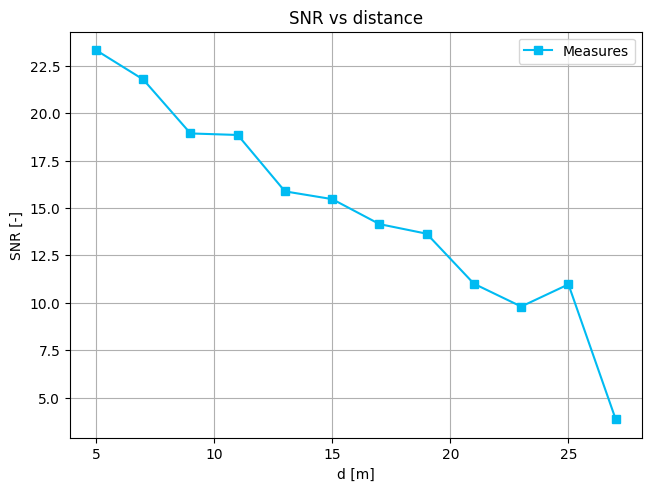

In [22]:
indices = np.argsort(d_plot)
SNR_mes = SNR_plot[indices]
d_mes= d_plot[indices]

ProcessBlue = "#00BBF2"

cut = 4
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(d_mes[:-cut], SNR_mes[:-cut], "-s", color=ProcessBlue, label="Measures")
ax.set_xlabel("d [m]")
ax.set_ylabel("SNR [-]")
#ax.set_yscale("log")

ax.grid(True)
ax.set_title("SNR vs distance")
ax.legend()
plt.savefig("SNR_dist_Meas.pdf")

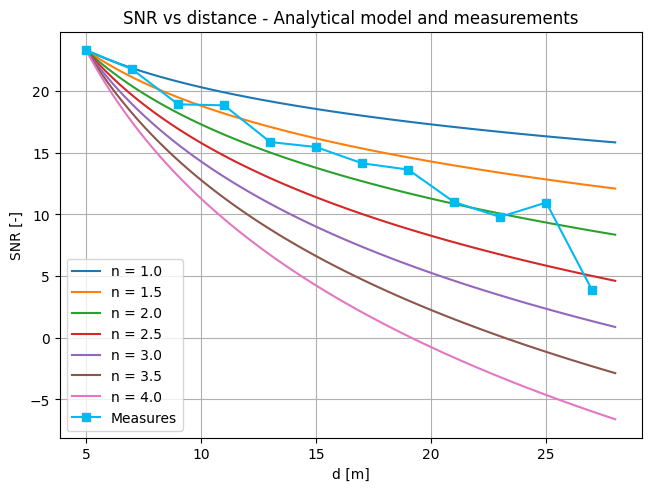

In [43]:
# Ideal curves
import matplotlib.pyplot as plt
import numpy as np

def compute_SNR(Tx, Rx, d, n, noise, SNR_mes):
    C = SNR_mes[0] - (10 * n * np.log10(d))[0]
    signal = Tx + Rx
    path_loss =  10 * n * np.log10(d) + C
    SNR = signal + noise - path_loss 
    return SNR

d = np.linspace(5,28,100)
Tx = 0 #dBm
Rx = 60 #dBm
noise = 10*np.log10(0.00025)


fig, ax = plt.subplots(constrained_layout=True)
ax.grid()

for n in np.arange(1,4.01,0.5):
    SNR = compute_SNR(Tx,Rx,d,n,noise,SNR_mes)
    ax.plot(d,SNR - (SNR[0]-SNR_mes[0]), label="n = {}".format(n))

ax.plot(d_mes[:-cut], SNR_mes[:-cut], "-s", color=ProcessBlue, label="Measures")
ax.legend()
ax.set_xlabel("d [m]")
ax.set_ylabel("SNR [-]")
ax.set_title("SNR vs distance - Analytical model and measurements")
plt.savefig("SNR_dist_cmpTh.pdf")

